In [1]:
import rasterio
from rasterio.plot import show
import rasterio.warp
import rasterio.mask
import shapely.geometry
from affine import Affine
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas
from osgeo import gdal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
points = 628
country_code = 'ZMB' # 'TZA' # 'NGA'
data_dir = "/capstone/cropmosaiks/data"  

In [3]:
file_name_weights_full = f'{data_dir}/weights/{country_code}_crop_weights_{points}k-points.feather'
file_name_country_shp = f'{data_dir}/boundaries/gadm36_{country_code}_2.shp'
print(file_name_weights_full,"\n", file_name_country_shp, sep = "")

/capstone/cropmosaiks/data/weights/ZMB_crop_weights_628k-points.feather
/capstone/cropmosaiks/data/boundaries/gadm36_ZMB_2.shp


<AxesSubplot:>

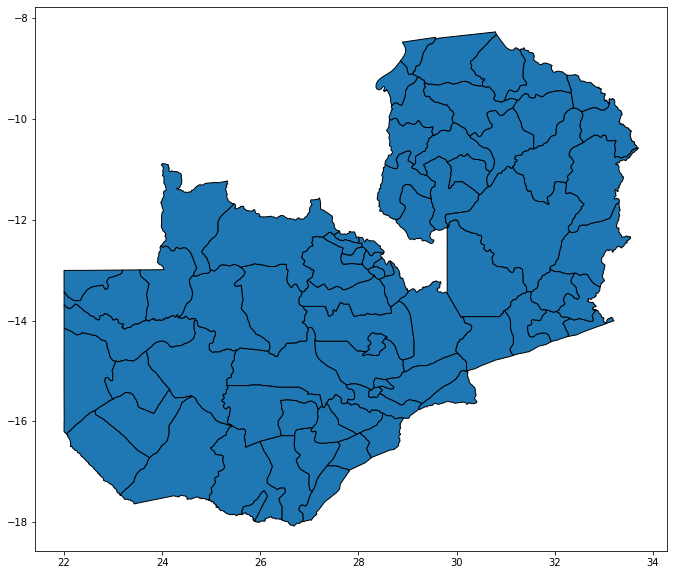

In [7]:
country_shp = geopandas.read_file(file_name_country_shp)
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_shp.plot(figsize = (12,10), edgecolor = "black")

In [8]:
crop_full = pd.read_feather(file_name_weights_full)

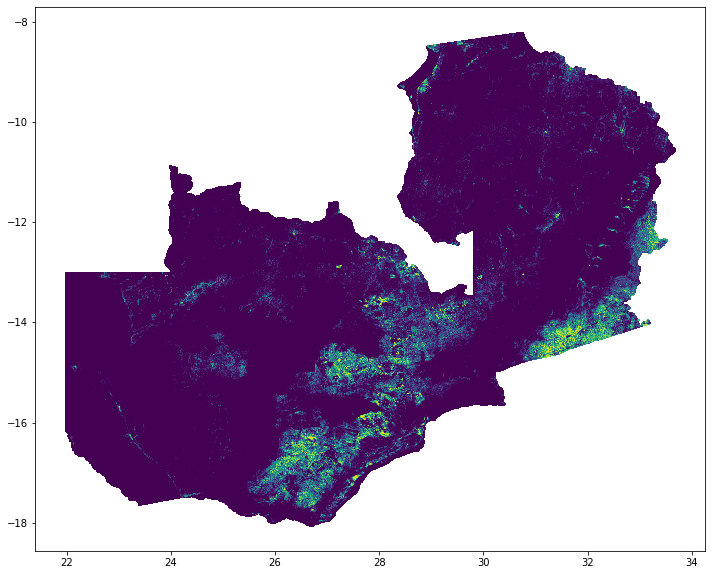

In [9]:
plt.figure(figsize = (12,10))
plt.scatter(crop_full.lon, crop_full.lat,  c=crop_full.crop_perc, s=.3, marker = ',')

In [11]:
crop_land = crop_full[crop_full.crop_perc > 0].reset_index(drop = True)

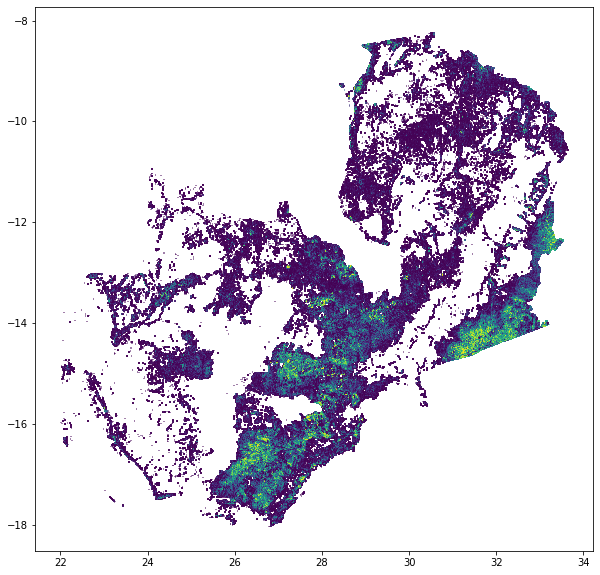

In [12]:
plt.figure(figsize = (10,10))
plt.scatter(crop_land.lon, crop_land.lat,  c=crop_land.crop_perc, s=.3, marker = ',')

In [13]:
crop_land = (
    geopandas
    .GeoDataFrame(
        crop_land, 
        geometry = geopandas.points_from_xy(x = crop_land.lon, y = crop_land.lat), 
        crs='EPSG:4326'
    )
)

In [14]:
df = (crop_land
     .sjoin(country_shp, how = 'left', predicate = 'within')
     .drop('index_right', axis = 1)
     .dropna(subset = ['district'])
     )

In [15]:
len(df.district.sort_values().unique())

72

In [25]:
percentage = 0.10
crop_land_top_10_per_dist = (
    df
    .groupby(['district'], as_index = False)
    .apply(lambda x: x.nlargest(int(x.count().max()*percentage),['crop_perc']))
    .reset_index(drop=True)
    .drop(['geometry', 'district'], axis = 1)
)
crop_land_top_10_per_dist = pd.DataFrame(crop_land_top_10_per_dist)

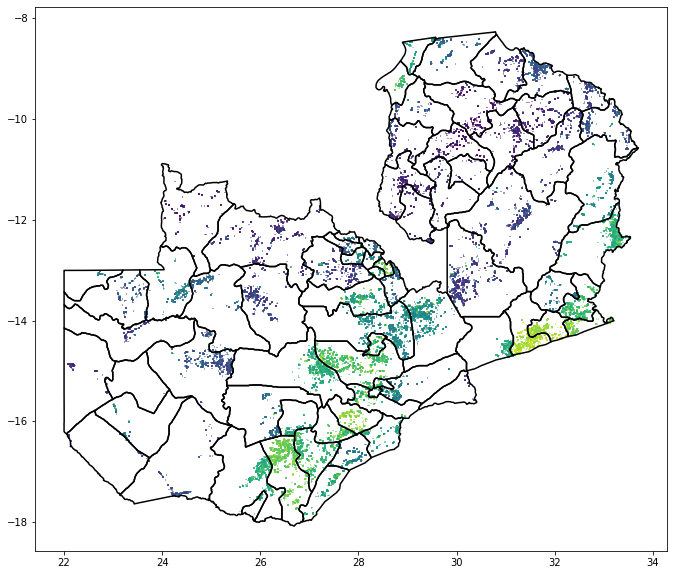

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
country_shp.boundary.plot(ax = ax, edgecolor = "black")
ax.scatter(x = crop_land_top_10_per_dist.lon, 
            y = crop_land_top_10_per_dist.lat, 
            c = crop_land_top_10_per_dist.crop_perc, 
            s = .3, marker = ',')

In [30]:
points = len(crop_land_top_10_per_dist)/1000
file_name = f'{data_dir}/weights/{country_code}_crop_weights_{points:0.0f}k-points.feather'
file_name

'/capstone/cropmosaiks/data/weights/ZMB_crop_weights_20k-points.feather'

In [33]:
print("Saving file as:", file_name)
crop_land_top_10_per_dist.to_feather(file_name)
print("Save finished!")

Saving file as: /capstone/cropmosaiks/data/weights/ZMB_crop_weights_20k-points.feather
Save finished!
